In [1]:
%matplotlib notebook

In [2]:
import calour as ca
import numpy as np
import pandas as pd
from calour.training import plot_roc
import matplotlib.pyplot as plt
ca.set_log_level(40)

First, we will load the table with relative abundance of 16S tag sequences (normalized to 100) in Ldlr and ApoE KO along with metadata about all samples in the study using calour (http://biocore.github.io/calour/). 
We are interested in looking at fecal metabolome in this study, so we will filter out all other sample types. Lastly, we just include samples from mice that were fed high-fat diet (HFD) as HFD promoted atherosclerosis in our animal models; this is the phenotype of interest. 

**Description of metadata columns that we use for this analysis**
1. body_habitat : type of sample (fecal, plasma, oral etc.)
2. diet : 'HFD' (High-fat diet) or 'Regular chow' given to mice
3. exposure_type : 'Air' or 'IHH' (intermittent hypoxia and hypercapnia) exposure
4. mouse_number : denotes unique mouse ID for each mouse in the study
5. genotype : 'ApoE KO' (ApoE knockout animals) or 'Ldlr knockout' 
6. age : age of mice in weeks (the study starts at 10 weeks of age)

In [3]:
ldlr = ca.read_amplicon('../data/microbiome/ldlr-deblur-refererence-hit-2k-wtax.biom', 
                        '../data/combined_sample_metadata_HFD.txt', normalize=100, min_reads=100)

apoe = ca.read_amplicon('../data/microbiome/apoe-deblur-reference-hit-2k-wtax.biom',
                        '../data/combined_sample_metadata_HFD.txt', normalize=100, min_reads=100)
# only retain fecal samples from mouse fed HFD
apoe = apoe.filter_samples('body_habitat', 'UBERON:feces').filter_samples('diet', 'HFD')

# combine the tables
exp = apoe.join_experiments(ldlr)

In [4]:
exp

AmpliconExperiment ("join apoe-deblur-reference-hit-2k-wtax.biom & ldlr-deblur-refererence-hit-2k-wtax.biom") with 642 samples, 8648 features

In [5]:
def plot_roc_mod(result, classes=None, title='ROC', cv=True, cmap=None,cmodel = 'darkviolet', ax=None):
    
    '''this function plots ROC curves for within model cross validation 
    and across model prediction'''
    
    from matplotlib import pyplot as plt
    import itertools
    from sklearn.metrics import roc_curve, auc
    from matplotlib import pyplot as plt
    from scipy import interp, stats
    from logging import getLogger
    logger = getLogger(__name__)
    
    if cmap is None:
        cmap = plt.cm.Dark2
    if ax is None:
        fig, ax = plt.subplots()

    ax.set_aspect('equal')
    ax.plot([0, 1], [0, 1], linestyle='-', lw=1, color='black', label='Luck', alpha=.5)

    if classes is None:
        classes = np.unique(result['Y_TRUE'].values)
        classes.sort()

    col = dict(zip(classes, itertools.cycle(cmap.colors)))

    mean_fpr = np.linspace(0, 1, 100)
    for cls in classes:
        tprs = []
        aucs = []
        if cv is True:
            for grp, df in result.groupby('CV'):
                if grp == -1:
                    y_true = df['Y_TRUE'].values == cls
                    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_true, df[cls])
                    roc_auc = auc(false_positive_rate, true_positive_rate)

                    ax.plot(false_positive_rate,true_positive_rate, color=cmodel, 
                         label = '{0} ({1:.2f})'.format('across model', roc_auc), linewidth=2)
                    continue
                else:
                    y_true = df['Y_TRUE'].values == cls
                    fpr, tpr, thresholds = roc_curve(y_true.astype(int), df[cls])
                    if np.isnan(fpr[-1]) or np.isnan(tpr[-1]):
                        logger.warning(
                            'The cross validation fold %r is skipped because the true positive rate or '
                            'false positive rate computation failed. This is likely because you '
                            'have either no true positive or no negative samples in this '
                            'cross validation for the class %r' % (grp, cls))
                        continue
                    mean_tpr = interp(mean_fpr, fpr, tpr)
                    tprs.append(mean_tpr)
                    tprs[-1][0] = 0.0
                    roc_auc = auc(mean_fpr, mean_tpr)
                    aucs.append(roc_auc)

            mean_tpr = np.mean(tprs, axis=0)
            mean_tpr[-1] = 1.0
            mean_auc = np.mean(aucs)
            std_auc = np.std(aucs)
            ax.plot(mean_fpr, mean_tpr, color=col[cls],
                    label = '{0} ({1:.2f})'.format('within model', roc_auc),
                    lw=2, alpha=.8)

            std_tpr = np.std(tprs, axis=0)
            tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
            tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
            ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color=col[cls], alpha=.5)

        else:
            y_true = result['Y_TRUE'].values == cls
            fpr, tpr, thresholds = roc_curve(y_true.astype(int), result[cls])
            if np.isnan(fpr[-1]) or np.isnan(tpr[-1]):
                logger.warning(
                    'The class %r is skipped because the true positive rate or '
                    'false positive rate computation failed. This is likely because you '
                    'have either no true positive or no negative samples for this class' % cls)
            roc_auc = auc(fpr, tpr)
            # prepend zero because, if not, the curve may start in the middle of the plot.
            ax.plot(np.insert(fpr, 0, 0), np.insert(tpr, 0, 0), label='{0} ({1:.2f})'.format(cls, roc_auc), lw=2)

    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title)
    ax.legend(loc="lower right")

    return ax

# ApoE and Ldlr KO models

In [6]:
# number of samples in each animal model
exp.sample_metadata.genotype.value_counts()

ApoE KO          460
LDLR knockout    182
Name: genotype, dtype: int64

Below, we perform abundance-based filtering of features to retain only high-quality reliable features that are present above a certain threshold (cutoff) in at least a certain fraction (fraction) of samples within each animal model. 
Here, we use an abundance threshold of 10E-6 and we want the feature to be present in atleast 1% of the samples in each animal model. We also filter out baseline samples (age = 10 & 10.5 weeks) as HFD was not yet introduced at these timepoints.

In [7]:
# filtering features if the abundance is less than 'cutoff' in 'fraction' of samples in either 'genotype'
exp2 = exp.filter_prevalence(field='genotype', cutoff=0.000001, fraction=0.01).filter_samples('age', [10, 10.5], 
                                                                                              negate=True)
exp2

AmpliconExperiment ("join apoe-deblur-reference-hit-2k-wtax.biom & ldlr-deblur-refererence-hit-2k-wtax.biom") with 582 samples, 437 features

In [8]:
# subset ApoE KO samples
exp2_apoe = exp2.filter_samples('genotype', 'ApoE KO')
exp2_apoe.sample_metadata.exposure_type.value_counts()

Air    211
IHH    201
Name: exposure_type, dtype: int64

In [9]:
# subset Ldlr KO samples
exp2_ldlr = exp2.filter_samples('genotype', 'LDLR knockout')
exp2_ldlr.sample_metadata.exposure_type.value_counts()

Air    85
IHH    85
Name: exposure_type, dtype: int64

## Classification using Random Forest (RF)

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, GroupKFold
from sklearn.metrics import roc_auc_score
from calour import training

### Train on ApoE KO & test on Ldlr KO

Below, we make a Random Forest (RF) model using microbiome data from ApoE KO animals. We use 5-fold cross-validation (CV) and ensure that samples belonging to the same mouse (denoted by 'mouse_number') are either in training or testing set for each train/test split. We used GroupKfold (http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html) for this.

In [11]:
it_apoe = exp2_apoe.classify('exposure_type',
                             RandomForestClassifier(n_estimators=500),
                             GroupKFold(5).split(
                                 exp2_apoe.data, exp2_apoe.sample_metadata['exposure_type'], 
                                 exp2_apoe.sample_metadata['mouse_number']))

In [12]:
# predictions for each CV fold
res_apoe = next(it_apoe)
res_apoe.head()

,Air,IHH,Y_TRUE,SAMPLE,CV
0,0.200,0.800,IHH,11548.A19.104.3,0
1,0.982,0.018,Air,11548.A21.112.11,0
2,0.916,0.084,Air,11548.A21.112.8,0
3,0.962,0.038,Air,11548.A22.113.17,0
4,0.078,0.922,IHH,11548.A20.105.17,0


<IPython.core.display.Javascript object>


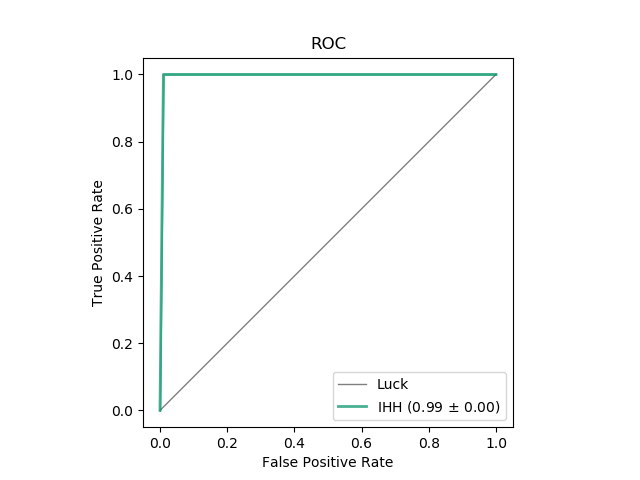

/Users/priya/miniconda3/envs/calour/lib/python3.5/site-packages/sklearn/metrics/ranking.py:563: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


In [13]:
# plot within model cross validation ROC
training.plot_roc(res_apoe, classes=['IHH'], cv=True)

In [15]:
# train RF classifier on all the samples from ApoE KO
clf_apoe = RandomForestClassifier(500, oob_score=True, random_state=0)
clf_apoe.fit(exp2_apoe.data, exp2_apoe.sample_metadata.exposure_type)
clf_apoe.oob_score_

0.99757281553398058

In [16]:
# predict IHH-exposure in Ldlr KO animals
res_apoe2ldlr = pd.DataFrame(clf_apoe.predict_proba(exp2_ldlr.data))
res_apoe2ldlr.columns = clf_apoe.classes_
res_apoe2ldlr['Y_TRUE'] = exp2_ldlr.sample_metadata['exposure_type'].values
res_apoe2ldlr['CV'] = -1 # we assign CV = -1 for these predictions as we don't need cross validation here

<IPython.core.display.Javascript object>


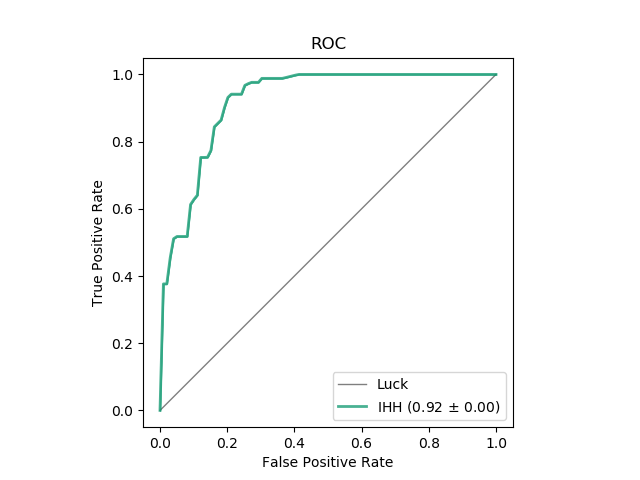

In [17]:
plot_roc(res_apoe2ldlr, classes=['IHH'])

/Users/priya/miniconda3/envs/calour/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


<IPython.core.display.Javascript object>


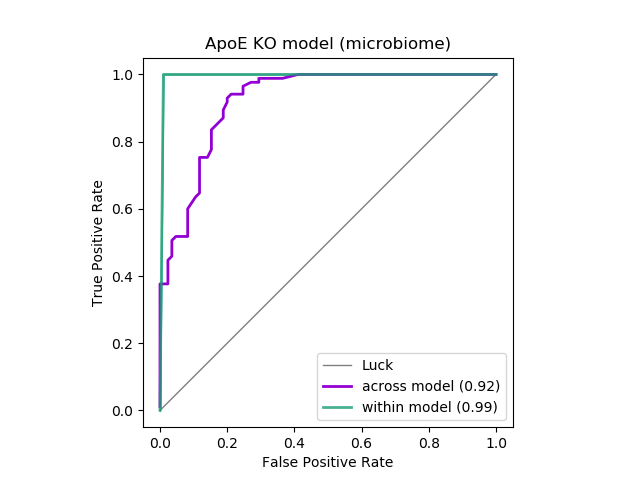

2018-08-24 11:04:45 WARNING The cross validation fold 4 is skipped because the true positive rate or false positive rate computation failed. This is likely because you have either no true positive or no negative samples in this cross validation for the class 'IHH'


/Users/priya/miniconda3/envs/calour/lib/python3.5/site-packages/sklearn/metrics/ranking.py:563: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


In [18]:
# plotting both ROC curves together
res_comb = pd.concat([res_apoe, res_apoe2ldlr])
fig = plot_roc_mod(res_comb, cmodel='darkviolet', classes=['IHH'], title = 'ApoE KO model (microbiome)').get_figure()
fig.savefig('../figures/auc_ApoEKOmodel_16S.pdf', bbox_to_inches='tight')

### Train on Ldlr KO & test on ApoE KO

Similar to above, we make a Random Forest (RF) model using microbiome data from Ldlr KO animals. We use 5-fold cross-validation (CV) and ensure that samples belonging to the same mouse (denoted by 'mouse_number') are either in training or testing set for each train/test split. We used GroupKfold (http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html) for this.

In [22]:
it_ldlr = exp2_ldlr.classify('exposure_type', RandomForestClassifier(n_estimators=500),
                             GroupKFold(5).split(
                                 exp2_ldlr.data, exp2_ldlr.sample_metadata['exposure_type'], 
                                 exp2_ldlr.sample_metadata['mouse_number']))

In [23]:
res_ldlr = next(it_ldlr)
res_ldlr.head()

,Air,IHH,Y_TRUE,SAMPLE,CV
0,0.108,0.892,IHH,10422.17.F.10,0
1,0.120,0.880,IHH,10422.17.F.11,0
2,0.052,0.948,IHH,10422.17.F.12,0
3,0.092,0.908,IHH,10422.17.F.13,0
4,0.174,0.826,IHH,10422.17.F.3,0


<IPython.core.display.Javascript object>


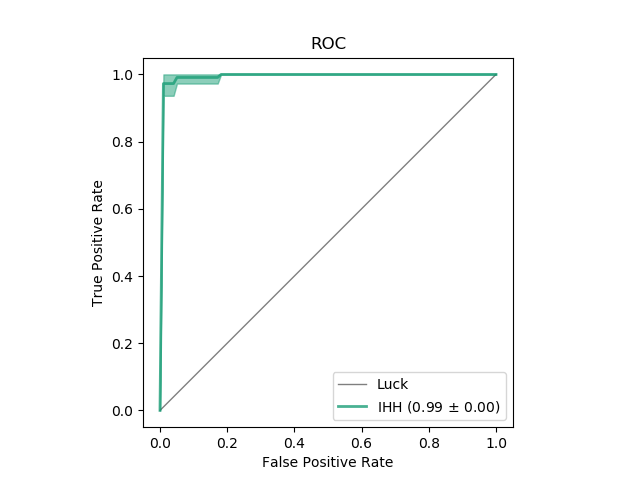

In [24]:
# plotting within model cross-validation ROC
plot_roc(res_ldlr, classes=['IHH'])

In [25]:
clf_ldlr = RandomForestClassifier(500, oob_score=True, random_state=10)
clf_ldlr.fit(exp2_ldlr.data, exp2_ldlr.sample_metadata.exposure_type)
clf_ldlr.oob_score_

0.96470588235294119

In [26]:
# predict IHH-exposure in ApoE KO animals
res_ldlr2apoe = pd.DataFrame(clf_ldlr.predict_proba(exp2_apoe.data))
res_ldlr2apoe.columns = clf_ldlr.classes_
res_ldlr2apoe['Y_TRUE'] = exp2_apoe.sample_metadata['exposure_type'].values
res_ldlr2apoe['CV'] = -1

<IPython.core.display.Javascript object>


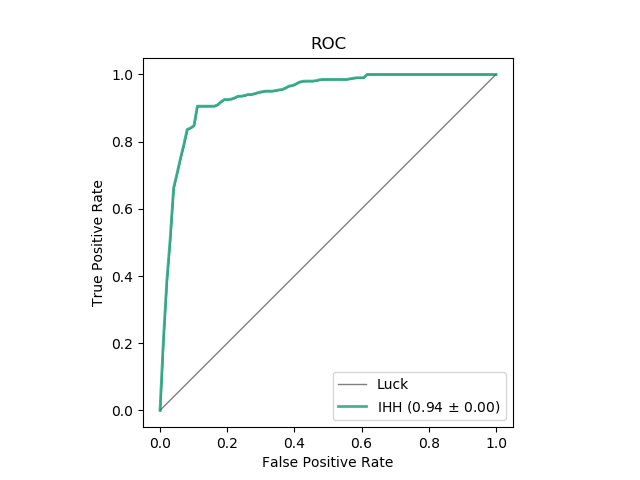

In [27]:
plot_roc(res_ldlr2apoe, classes=['IHH'])

/Users/priya/miniconda3/envs/calour/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


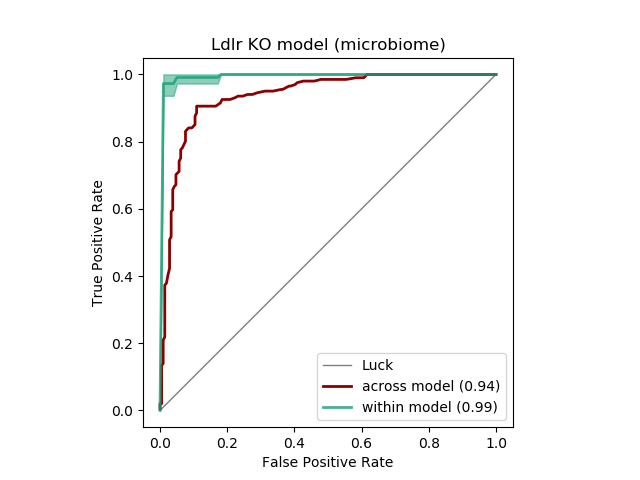

In [28]:
res_comb = pd.concat([res_ldlr, res_ldlr2apoe])
fig = plot_roc_mod(res_comb, cmodel='darkred', classes=['IHH'], title = 'Ldlr KO model (microbiome)').get_figure()
fig.savefig('../figures/auc_LdlrKOmodel_16S.pdf', bbox_to_inches='tight')